# Run model on fake data

Here, we generate a synthetic data set for purposes of validating the model constructed in Edward.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ed.set_seed(12225)

The model is defined by the spike count $N_{us}$ observed when stimulus $s$ is presented to unit $u$:

$$
\begin{align}
N &\sim \mathrm{Poisson}((\lambda)_+)  \\
\lambda_{us} &\sim \mathcal{N}(A_{u} + (B * X)_{us} + (C * Z)_{us}, \sigma^2) \\
\log \sigma &\sim \mathcal{N}(-0.1, 0.1^2) \\
Z_{ks} &\sim \mathrm{Bernoulli}(\pi_k) \\
\pi_k &\equiv \prod_{i=1}^k \delta_k \\
\delta_j &\sim \mathrm{Beta}(3, 1)
\end{align}
$$
With $X$ an $P \times N_s$ matrix of known regressors, $Z$ a $K \times N_s$ matrix of latent binary features
governed by an Indian Buffet Process, $A$ and $N_u$ vector of baselines, and $(\cdot)_+$ the softplus function: 
$(x)_+ = \log(1 + e^x)$.

# Define constants

In [3]:
# basic constants
N = 5  # number of observations per unit per stim
NB = 10  # number of trials in minibatch
NU = 50  # number of units
NS = 50  # number of stims
P = 3  # number of specified regressors
K = 4  # number of latents

# Make neural response coefficients

In [4]:
dA = 5 + 2 * np.random.randn(NU)  # baseline
dB = np.array([0, 5, 10]) + 0.25 * np.random.randn(NU, P)  # regressor effects
dC = np.array([-10, -5, 5, 10])[np.newaxis, :] + 0.25 * np.random.randn(NU, K)  # latent effects

# Regressors and latent states

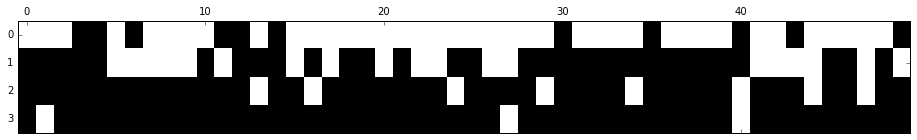

In [5]:
dX = 1 + np.random.randn(P, NS)

import scipy.stats as stats

ddelta = stats.beta.rvs(1.2, 1, size=(K,))
dpi = np.cumprod(ddelta)
dZ = stats.bernoulli.rvs(dpi[:, np.newaxis], size=(K, NS))

# plot states
plt.matshow(dZ, aspect='auto', cmap='gray')

# Generate trial set

In [6]:
dU, dS = np.meshgrid(range(NU), range(NS))
dU = dU.ravel()
dS = dS.ravel()

In [7]:
dlam_mean = dA[dU] + np.sum(dB[dU] * dX[:, dS].T, axis=1) + np.sum(dC[dU] * dZ[:, dS].T, axis=1)

dlam = stats.norm.rvs(loc=dlam_mean, scale=0.1)

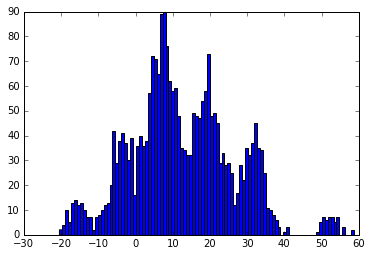

In [8]:
plt.hist(dlam, bins=100);

In [9]:
# we'll want this function below
def softplus(x):
    return np.logaddexp(0, x)

In [10]:
dcount = stats.poisson.rvs(softplus(dlam))

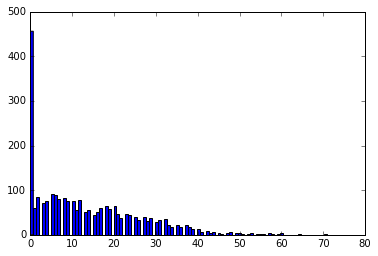

In [11]:
plt.hist(dcount, bins=100);

# Set up data

In [12]:
count = dcount
Xdat = dX[:, dS].T
Xdat.shape
unit = dU
stim = dS

# Define the model

## Constants

In [13]:
# define some needed constants
N = Xdat.shape[0]  # number of trials

## Inputs and data

In [14]:
X = tf.constant(Xdat.astype('float32'))
U = tf.constant(unit)
S = tf.constant(stim)
counts = tf.constant(count)
allinds = tf.constant(np.arange(N))

Make a node that produces `NB` indices from the range $[0, N - 1]$. These are the subset of data points we want to use.

In [15]:
batch_inds, batch_counts = tf.train.batch(tf.train.slice_input_producer([allinds, counts]), NB, 
                                          name='batches')

## Generative (p) model

In [16]:
with tf.variable_scope("pmodel"):
    A = ed.models.Normal(mu=tf.zeros(NU), sigma=tf.ones(NU), name='A')
    B = ed.models.Normal(mu=tf.zeros((NU, P)), sigma=tf.ones((NU, P)), name='B')
    C = ed.models.Normal(mu=tf.zeros((NU, K)), sigma=tf.ones((NU, K)), name='C')  
    
    delta = ed.models.Beta(a=3 * tf.ones(K), b=tf.ones(K), name='delta')
    tf.scalar_summary('mean_delta', tf.reduce_mean(delta))
    log_delta = tf.log(delta)
    tf.scalar_summary('min_log_delta', tf.reduce_min(log_delta))
    tf.scalar_summary('mean_log_delta', tf.reduce_mean(log_delta))

    pi = tf.exp(tf.cumsum(log_delta), name='pi')
    tf.scalar_summary('min_pi', tf.reduce_min(pi))

    Z = ed.models.Bernoulli(p=tf.tile(tf.expand_dims(pi, 0), [NS, 1]), name='Z')
    tf.scalar_summary('mean_Z', tf.reduce_mean(tf.to_float(Z)))

    sig = ed.models.Normal(mu=[-0.1], sigma=[0.1], name='sig')

    lam_vars = (tf.gather(A, U) + tf.reduce_sum(tf.gather(B, U) * X, 1) + 
           tf.reduce_sum(tf.gather(C, U) * tf.gather(tf.to_float(Z), S), 1))
    lam = ed.models.Normal(mu=tf.gather(lam_vars, batch_inds), 
                           sigma=tf.exp(sig), name='lam')
    tf.scalar_summary('mean_lam', tf.reduce_mean(lam))


    cnt = ed.models.Poisson(lam=tf.nn.softplus(lam), value=tf.ones(NB), name='cnt')

# Recognition (q) model

In [17]:
with tf.variable_scope("qmodel"):
    q_A = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU,))), 
                                            sigma=tf.Variable(tf.random_uniform((NU,))),
                                            name='A')
    q_B = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, P))), 
                                            sigma=tf.Variable(tf.random_uniform((NU, P))),
                                            name='B')
    q_C = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, K))), 
                                            sigma=tf.Variable(tf.random_uniform((NU, K))),
                                            name='C')
    q_Z = ed.models.BernoulliWithSigmoidP(p=tf.Variable(tf.random_normal((NS, K))), name='Z')
    tf.scalar_summary('mean_q_Z', tf.reduce_mean(tf.to_float(Z)))

    q_delta = ed.models.BetaWithSoftplusAB(a=tf.Variable(1 + tf.random_uniform((K,))),
                                           b=tf.Variable(1 + tf.random_uniform((K,))),
                                           name='delta')
    tf.scalar_summary('mean_q_delta', tf.reduce_mean(q_delta))

    lam_mu = tf.Variable(tf.random_normal((N,)))
    lam_sig = tf.Variable(tf.random_uniform((N,)))
    q_lam = ed.models.NormalWithSoftplusSigma(mu=tf.gather(lam_mu, batch_inds),
                                              sigma=tf.gather(lam_sig, batch_inds),
                                              name='lam')
    tf.scalar_summary('mean_q_lam', tf.reduce_mean(q_lam))

    q_sig = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(-0.1 * tf.random_uniform((1,))),
                                              sigma=tf.Variable(tf.random_uniform((1,))),
                                              name='sig')
    tf.scalar_summary('mean_q_sig', tf.reduce_mean(q_sig))


# Do variational inference

In [18]:
data = {cnt: batch_counts}
inference = ed.KLqp({A: q_A, B: q_B, C: q_C, Z: q_Z, sig: q_sig, delta: q_delta, lam: q_lam}, 
                    data)

In [19]:
init = tf.initialize_all_variables()

# Notes before inference:

- The `logdir` keyword specifies the place to put the log file (assuming you've instrumented the code to save events, etc.). If a subdirectory is given, pointing Tensorboard at the parent directory allows you to compare across subdirectories (runs).
    - I'm using the `jmp/instrumented` branch of the `jmxpearson/edward` fork
- I had to lower the learning rate in Adam to avoid NaNs early on in learning. Gradient clipping might solve the same problem.
- I'm currently using "all" the data, but this should probably be switched to minibatches.
- I've used `n_samples` = 1, 5, 10, and 25, which all seem pretty similar after 10k iterations. 

In [20]:
inference.run(n_iter=30000, n_print=100, n_samples=1,
              logdir='data/run1',
              optimizer=tf.train.AdamOptimizer(1e-3),
              scale={lam: N/NB, cnt: N/NB})

Iteration     1 [  0%]: Loss = 18631.346
Iteration   100 [  0%]: Loss = 150930.438
Iteration   200 [  0%]: Loss = 3586.414
Iteration   300 [  1%]: Loss = 5054.804
Iteration   400 [  1%]: Loss = 3198.501
Iteration   500 [  1%]: Loss = 17516.754
Iteration   600 [  2%]: Loss = 44975.336
Iteration   700 [  2%]: Loss = 4737.905
Iteration   800 [  2%]: Loss = 21274.695
Iteration   900 [  3%]: Loss = 15562.155
Iteration  1000 [  3%]: Loss = 3287.508
Iteration  1100 [  3%]: Loss = 127264.461
Iteration  1200 [  4%]: Loss = 49329.840
Iteration  1300 [  4%]: Loss = 6449.157
Iteration  1400 [  4%]: Loss = 5887.796
Iteration  1500 [  5%]: Loss = 95612.703
Iteration  1600 [  5%]: Loss = 2264.280
Iteration  1700 [  5%]: Loss = 4359.103
Iteration  1800 [  6%]: Loss = 6036.480
Iteration  1900 [  6%]: Loss = 3713.784
Iteration  2000 [  6%]: Loss = 48110.477
Iteration  2100 [  7%]: Loss = 7381.340
Iteration  2200 [  7%]: Loss = 51745.797
Iteration  2300 [  7%]: Loss = 23350.055
Iteration  2400 [  8%]: Lo

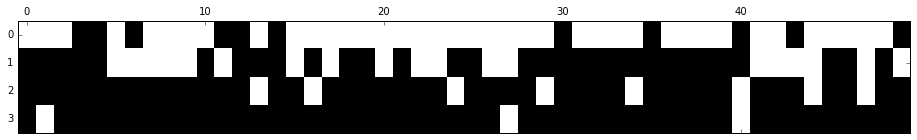

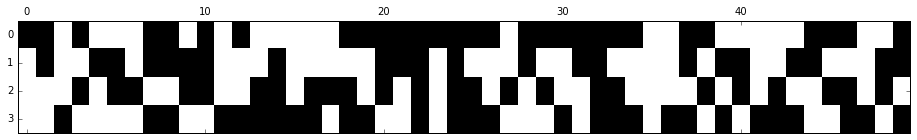

In [21]:
Zmat = q_Z.value().eval()

plt.matshow(dZ, aspect='auto', cmap='gray')
plt.matshow(Zmat.T, aspect='auto', cmap='gray')